# Megafon 

## Steps

1. First look at data
    - read train test
    - common ids
    - read features (20 GB)
    - 



### First look at data

#### Read train test

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd  # for big file feature.csv ~20 Gb
import matplotlib.pyplot as plt
import datetime

plt.style.use('ggplot')
pd.options.mode.chained_assignment = None  # avoid warning

In [185]:
train = pd.read_csv('data/data_train.csv', index_col=0)
train.head(2)

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0


In [186]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        831653 non-null  int64  
 1   vas_id    831653 non-null  float64
 2   buy_time  831653 non-null  int64  
 3   target    831653 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 31.7 MB


#### Look at Target distribution

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

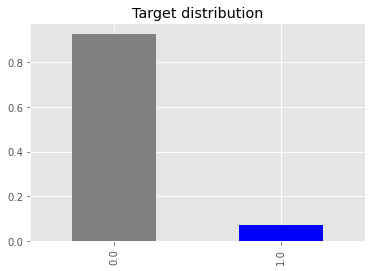

In [4]:
(train['target'].value_counts()/train['target'].shape[0]).\
    plot(kind='bar', title='Target distribution', color = ['grey', 'blue']);
train['target'].value_counts()/train['target'].shape

Not very balanced sample

In [187]:
test = pd.read_csv('data/data_test.csv', index_col=0)
test.head(2)

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000


In [188]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71231 entries, 0 to 71230
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        71231 non-null  int64  
 1   vas_id    71231 non-null  float64
 2   buy_time  71231 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 2.2 MB


#### Common ids

There are extra indexes in the `feature.csv` file. Need to select rows without them.

In [189]:
train_ids = set(train.id.tolist())
test_ids = set(test.id.tolist())
common_ids = train_ids.union(test_ids)

print(f'Number train indexes: {len(train_ids)} \n\
Number test indexes: {len(test_ids)} \nNumber common indexes: {len(common_ids)}')

Number train indexes: 806613 
Number test indexes: 70152 
Number common indexes: 872577


#### Read features (~20 GB)

In [8]:
# features = dd.read_csv('data/features.csv', sep='\t')
# features

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
npartitions=351,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [9]:
# %%time
# features = features[features.id.isin(common_ids)].compute()
# features.head(2)

CPU times: user 8min 41s, sys: 1min 20s, total: 10min 2s
Wall time: 3min 53s


,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
13,13,2046132,1534712400,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
16,16,2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [10]:
# features.drop(columns='Unnamed: 0', inplace=True)
# features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902389 entries, 13 to 12844
Columns: 255 entries, id to 252
dtypes: float64(253), int64(2)
memory usage: 1.7 GB


#### Save to parquet

Now we can save `features` in a binary file format - `Parquet`, and we can also delete large `CSV` files.

In [13]:
# %%time
# features.to_parquet('data/features_common_ids.parquet')

CPU times: user 6.53 s, sys: 1.84 s, total: 8.37 s
Wall time: 5.97 s


File size of `features_common_ids.parquet` ~200 Mb.

In [8]:
%%time
features = pd.read_parquet('data/features_common_ids.parquet')
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902389 entries, 13 to 12844
Columns: 255 entries, id to 252
dtypes: float64(253), int64(2)
memory usage: 1.7 GB
CPU times: user 3.38 s, sys: 8.98 s, total: 12.4 s
Wall time: 5.16 s


#### Communication

In [10]:
def unique_ids(df):
    return df.groupby(by='id')['id'].agg('count').value_counts()

In [11]:
unique_ids(train)

1    781611
2     24964
3        38
Name: id, dtype: int64

In [12]:
unique_ids(test)

1    69092
2     1041
3       19
Name: id, dtype: int64

In [13]:
unique_ids(features)

1    842765
2     29812
Name: id, dtype: int64

Most of the indices are unique, but there are those that occur two or three times.

In [14]:
thrice_ids = train.groupby(by='id')['id'].agg('count')[train.groupby(by='id')['id'].agg('count') == 3].index.tolist()

In [15]:
tr_temp = train[train['id'].isin(set(thrice_ids) & common_ids)].head(100)
tr_temp.head(9)

,id,vas_id,buy_time,target
21564,1144355,4.0,1544994000,0.0
21565,1144355,4.0,1545598800,0.0
21566,1144355,6.0,1544994000,1.0
24239,3475168,1.0,1544994000,0.0
24240,3475168,4.0,1542574800,0.0
24241,3475168,6.0,1542574800,1.0
24631,271692,2.0,1543179600,0.0
24632,271692,4.0,1546203600,0.0
24633,271692,6.0,1546203600,1.0


There were several communications for these clients. This won't have much effect on our model, so let's leave it as it is.

### Baseline - LGBM

We use LightGBM for the baseline because it is fast and does not require extensive data preparation.

#### Time

Sorting the target variable by time and visualization

In [25]:
time_buy = pd.to_datetime(train[train['target'] == 1]['buy_time'], unit='s')\
                                                .sort_values(ascending=False).value_counts(sort=False)
time_notbuy = pd.to_datetime(train[train['target'] == 0]['buy_time'], unit='s')\
                                                .sort_values(ascending=False).value_counts(sort=False)


In [125]:
def plot_distribution(buy, notbuy, fig_size=(14, 6), width=2, 
                      set_axis=False, modifided_axis=[0.0, 10.5, 0.0, 105000.0],
                      title='Distribution of purchases', ylabel='Count of targets', xlabel='buy_time'):
    plt.figure(figsize=fig_size)
    plt.bar(notbuy.index, notbuy, width=width, color='grey', alpha=0.9)
    plt.bar(buy.index, buy, width=width*2, color='b', alpha=0.6)
    if set_axis:
        plt.axis(modifided_axis)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # plt.yscale('log')
    plt.show()

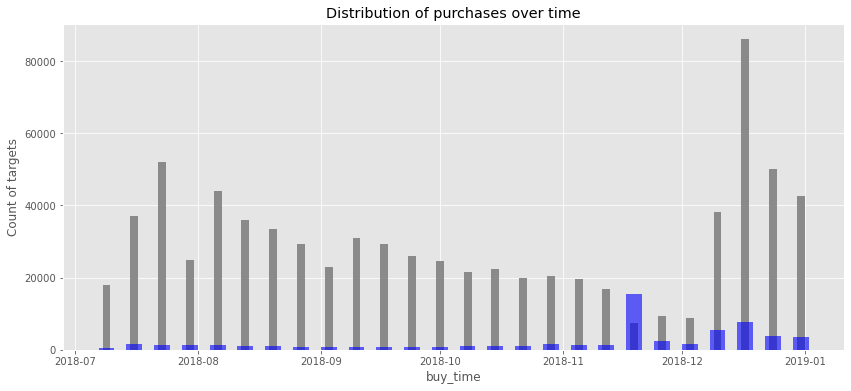

In [122]:
plot_distribution(time_buy, time_notbuy, title='Distribution of purchases over time')

Seasonal distribution of purchases and **peak** sales on the same day in November (Sale). Using **incomplete** seasonal data to evaluate the model is not the best solution. But it's a challenge.

We can try to make the **last month** (December) as a validation sample

#### Train valid split

As mentioned earlier, let's try to make the last month (December) as a test sample

In [46]:
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report, f1_score, auc

import lightgbm

In [27]:
SPLIT_DATE = np.datetime64('2018-12-01T00:00:00').astype(np.int64)
SPLIT_DATE

1543622400

In [28]:
# train.set_index('id', inplace=True)
# test.set_index('id', inplace=True)

In [37]:
# def train_valid_split(train, split_date):
#     X_train = train[train['buy_time'] < split_date]
#     X_val = train[train['buy_time'] >= split_date]

#     y_train = X_train['target']
#     y_val = X_val['target']
    
#     # convert time to timestamp int64
#     X_train.loc[:, 'buy_time'] = X_train.loc[:, 'buy_time'].values.astype(np.int64) // 10 ** 9
#     X_train.loc[:, 'update_info_time'] = X_train['update_info_time'].values.astype(np.int64) // 10 ** 9

#     X_val.loc[:, 'buy_time'] = X_val.loc[:, 'buy_time'].values.astype(np.int64) // 10 ** 9
#     X_val.loc[:, 'update_info_time'] = X_val.loc[:, 'update_info_time'].values.astype(np.int64) // 10 ** 9
    
#     X_train.set_index('id', inplace=True)
#     X_val.set_index('id', inplace=True)
    
#     return X_train, y_train, X_val, y_val

In [190]:
def train_valid_split(train, split_date, drop_columns='target'):
    X_train = train[train['buy_time'] < split_date].copy(deep=True)
    X_val = train[train['buy_time'] >= split_date].copy(deep=True)

    y_train = X_train['target']
    y_val = X_val['target']

    X_train.drop(columns=drop_columns, inplace=True)
    X_val.drop(columns=drop_columns, inplace=True)
    
    # X_train.set_index('id', inplace=True)
    # X_val.set_index('id', inplace=True)
    
    return X_train, y_train, X_val, y_val

In [191]:
%%time
X_train, y_train, X_val, y_val = train_valid_split(train, SPLIT_DATE)

CPU times: user 44 ms, sys: 19.4 ms, total: 63.4 ms
Wall time: 63.1 ms


In [192]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((584073, 3), (584073,), (247580, 3), (247580,))

#### Fit

In [193]:
%%time
lgb = lightgbm.LGBMClassifier(objective='binary', random_state=1)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_val)

CPU times: user 7.78 s, sys: 164 ms, total: 7.95 s
Wall time: 1.24 s


In [194]:
train_preds[:, 1]

array([0.01640412, 0.01091588, 0.01395224, ..., 0.01535436, 0.01161617,
       0.01263035])

In [211]:
f1_score(y_val, train_preds[:, 1] > 0.5, average='macro')

0.7271900451361183

#### Best threshold

Looking for the best threshold

In [341]:
def find_best_threshold(y_true, y_pred, do_print=False, macro=False):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    # avoid zeros
    precision[precision == 0] = 1e-9
    recall[recall == 0] = 1e-9
    
    if macro:
        # average = 'macro'. This work slowly ~ 1.5 min.
        fscore = []
        for th in thresholds:
            fscore.append(f1_score(y_true, y_pred >= th, average='macro'))
        fscore = np.asarray(fscore)
    else:
        # average = 'binary'. This work fast.
        fscore = (2 * precision * recall) / (precision + recall)
    
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    best_threshold = thresholds[ix]
    if do_print:
        print(f'Best Threshold = {best_threshold:.3f}, F-Score = {fscore[ix]:.3f}, \
Precision = {precision[ix]:.3f}, Recall = {recall[ix]:.3f}')
    return best_threshold

In [342]:
best_threshold = find_best_threshold(y_val, train_preds[:, 1], do_print=True)

Best Threshold = 0.252, F-Score = 0.575, Precision = 0.420, Recall = 0.914


In [235]:
%%time
best_threshold = find_best_threshold(y_val, train_preds[:, 1], do_print=True, macro=True)

Best Threshold = 0.305, F-Score = 0.753, Precision = 0.426, Recall = 0.880
CPU times: user 1min 13s, sys: 2.2 s, total: 1min 15s
Wall time: 1min 15s


In [232]:
f1_score(y_val, train_preds[:, 1] >= best_threshold, average='macro')

0.7530341580965332

In [247]:
print(classification_report(y_val, train_preds[:, 1] >= best_threshold))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    225378
         1.0       0.42      0.91      0.58     22202

    accuracy                           0.88    247580
   macro avg       0.71      0.89      0.75    247580
weighted avg       0.94      0.88      0.90    247580



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

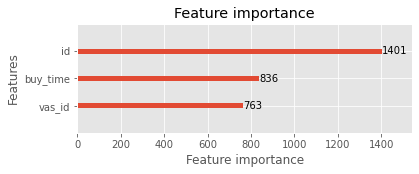

In [55]:
lightgbm.plot_importance(lgb, figsize=(6, 2))

Look at the `vas_id` feature

In [74]:
vas_buy = train[train['target'] == 1].groupby('vas_id')['vas_id'].agg('count')
vas_notbuy = train[train['target'] == 0].groupby('vas_id')['vas_id'].agg('count')

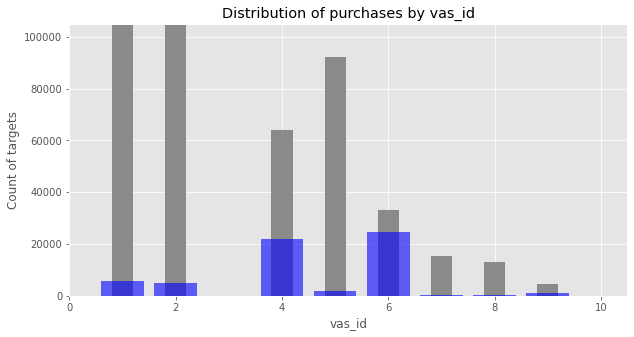

In [124]:
plot_distribution(vas_buy, vas_notbuy, fig_size=(10, 5), width=0.4, 
                      set_axis=True, modifided_axis=[0.0, 10.5, 0.0, 105000.0],
                      title='Distribution of purchases by vas_id', xlabel='vas_id')

`vas_id` can still be explained by the **influence** of services **4** and **6**, because they are **most** often connected. But how **interestingly** the `id` affects the model.

#### Visualisation. ROC Curve, PR Curve

In [53]:
# def plot_roc_curve(y_true, y_pred, model_name="Noname", color='b', ax=None):
#     fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred)
    
#     plt.figure(figsize=(6, 6)) 
#     plt.plot(fpr, tpr, label='%s: ROC Curve (area = %0.3f)' %
#              (model_name, auc(fpr, tpr)), color=color)
#     plt.plot([0, 1], [0, 1], 'k--')  # diagonal
#     plt.axis([0.0, 1.0, 0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve')
#     plt.legend(loc="lower right")

In [54]:
# def plot_precision_recall_curve(y_true, y_pred, model_name="Noname", color='b'):
#     precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    
#     plt.figure(figsize=(6, 6)) 
#     plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.3f)' %
#              (model_name, auc(recall, precision)), color=color)
#     plt.axis([0.0, 1.0, 0.0, 1.05])
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title("Precision-Recall curve")
#     plt.legend(loc="lower left")

In [55]:
# plot_roc_curve(y_val, train_preds[:, 1], "Baseline", color='b')
# plot_precision_recall_curve(y_val, train_preds[:, 1], "Baseline", color='b')

In [126]:
def plot_roc_pr_curve(y_true, y_pred, model_name="Noname", color='b'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # plot ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred)
    ax1.plot(fpr, tpr, label='%s: ROC Curve (area = %0.3f)' %
             (model_name, auc(fpr, tpr)), color=color)
    ax1.axis([0.0, 1.0, 0.0, 1.05])
    ax1.plot([0, 1], [0, 1], 'r--')  # diagonal
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc="lower right")
    
    # plot Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    ax2.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.3f)' %
             (model_name, auc(recall, precision)), color=color)
    ax2.axis([-0.05, 1.05, 0.0, 1.05])
    # ax2.plot([0.8, 0.8], [0, 1], 'g--')  # best Recall
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title("Precision-Recall curve")
    ax2.legend(loc="lower left")

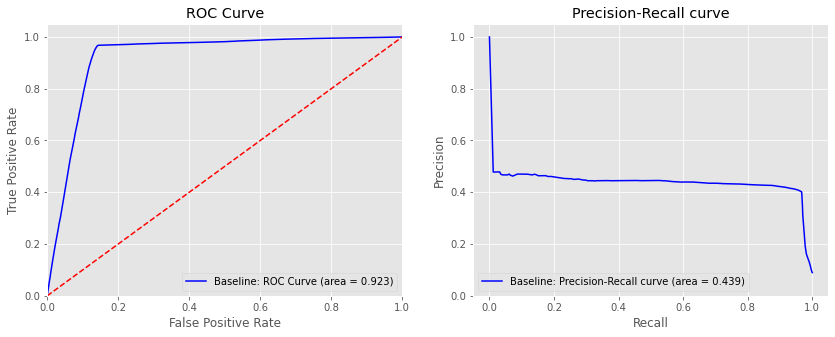

In [127]:
plot_roc_pr_curve(y_val, train_preds[:, 1], "Baseline", color='b')

#### Conclusion for baseline:

Not so bad performance for the baseline. As can be seen from the plot of the **PR Curve**, it is easy to find ~90% **Recall** for this model without compromising the **Precision**.

### Features

Let's look at the **features** and process them

#### Perform an asof merge.

In [128]:
# feature time it's time of update information about client
features.rename( columns={'buy_time':'update_info_time' } ,inplace=True) 

In [129]:
def merge_asof(left, right, ids):
    left = pd.merge_asof(left.sort_values(by=['buy_time']), 
                         right[features.id.isin(ids)].sort_values(by=['update_info_time']), 
                         left_on='buy_time', 
                         right_on='update_info_time', 
                         by='id',
                         direction='nearest'  # with nearest time
                         )
    return left

In [201]:
%%time
train = merge_asof(train, features, train_ids)
train.head(2)

CPU times: user 7.06 s, sys: 12.2 s, total: 19.2 s
Wall time: 26.9 s


,id,vas_id,buy_time,target,update_info_time,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
0,2582523,2.0,1531083600,0.0,1544994000,314.560029,9.290888,342.989214,7.523202,337.571754,...,6488.626154,-574.770792,-24.996269,121.369552,142.252276,-16.832889,-0.694428,-11.175933,-0.45614,0.0
1,1292549,2.0,1531083600,0.0,1537131600,93.880029,-217.499112,79.939214,-270.106798,74.521754,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [202]:
%%time
test = merge_asof(test, features, test_ids)
test.head(2)

CPU times: user 868 ms, sys: 2.94 s, total: 3.81 s
Wall time: 5.34 s


,id,vas_id,buy_time,update_info_time,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,2905850,5.0,1546808400,1536526800,326.930029,227.410888,312.989214,200.223202,307.571754,179.11821,...,-464.373846,-104.770792,-25.996269,-18.630448,-209.747724,-15.832889,-0.694428,-2.175933,-0.45614,0.0
1,31619,2.0,1546808400,1536526800,-96.799971,100.290888,-62.040786,250.953202,-67.458246,229.84821,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


#### Run function

Let's try to learn model with `features` and without feature engineering

In [443]:
def run_learn(train, model, slpit_date=SPLIT_DATE, drop_columns='target', plot_name='Noname'):
    # split
    X_train, y_train, X_val, y_val = train_valid_split(train, slpit_date, drop_columns)

    # models
    # lgb = lightgbm.LGBMClassifier(objective='binary', random_state=1)
    model.fit(X_train, y_train)
    train_preds = model.predict_proba(X_val)

    # metrics
    best_threshold = find_best_threshold(y_val, train_preds[:, 1], do_print=True)
    f1 = f1_score(y_val, train_preds[:, 1] >= best_threshold, average='macro')
    print(f'F1-Score (average="macro") = {f1}')
    
    plot_roc_pr_curve(y_val, train_preds[:, 1], plot_name, color='b')
    
    return model

In [444]:
lgb = lightgbm.LGBMClassifier(objective='binary', random_state=1)

Best Threshold = 0.260, F-Score = 0.576, Precision = 0.421, Recall = 0.910
F1-Score (average="macro") = 0.7526978806388435
CPU times: user 1min 9s, sys: 19.2 s, total: 1min 28s
Wall time: 42.4 s


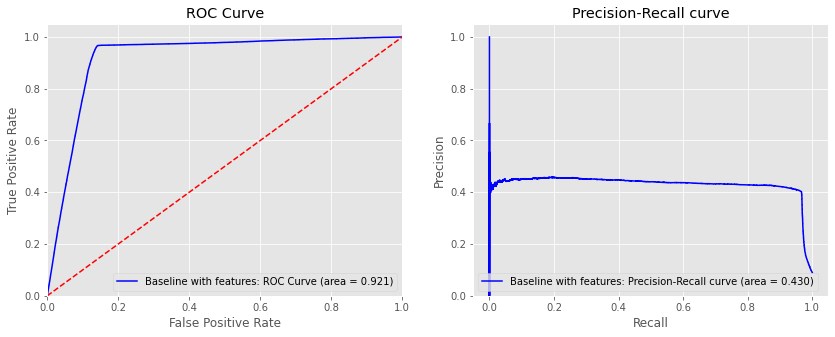

In [445]:
%%time
lgb = run_learn(train, lgb, slpit_date=SPLIT_DATE, plot_name='Baseline with features')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

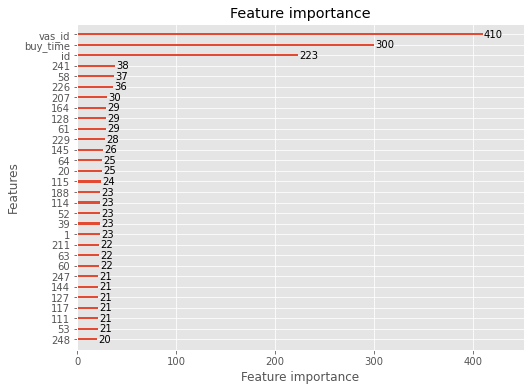

In [346]:
lightgbm.plot_importance(lgb, figsize=(8, 6) , max_num_features=30)

The scores **haven't changed** much. There is no strong influence of `features`.

#### Dublicates

In [132]:
%%time
f = features.copy()
f.set_index('id', inplace=True)

print("Are there duplicates in the rows? --> ", f.duplicated().sum())
print("What percentage features can be Null? --> %d%%" % float((f.isnull().sum() > 0).sum()/f.shape[1]*100))

Are there duplicates in the rows? -->  1422
What percentage features can be Null? --> 0%
CPU times: user 9.16 s, sys: 6.67 s, total: 15.8 s
Wall time: 19.6 s


In [133]:
%%time
f_duplicated = f[f.duplicated()]
f_duplicated.shape

CPU times: user 6.94 s, sys: 2.49 s, total: 9.43 s
Wall time: 9.97 s


(1422, 254)

In [134]:
f_dupl_ids = set(f_duplicated.index.tolist())
len(f_dupl_ids)

1418

In [135]:
print(f'There are duplicate indexes for the train dataset: {len(f_dupl_ids.intersection(train_ids))}')

There are duplicate indexes for the train dataset: 1318


In [136]:
print(f'There are duplicate indexes for the test dataset: {len(f_dupl_ids.intersection(test_ids))}')

There are duplicate indexes for the test dataset: 103


In [137]:
f_duplicated.head(3)

,update_info_time,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
3121327,1545598800,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,-16.08618,-65.076097,-6.78366,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1638049,1545598800,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,-16.08618,-65.076097,-6.78366,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3494546,1546808400,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,-16.08618,-65.076097,-6.78366,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [144]:
train[train['id'].isin([3121327, 1638049])]

,id,vas_id,buy_time,target,update_info_time,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
171499,1638049,1.0,1533502800,0.0,1545598800,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
172919,3121327,1.0,1533502800,0.0,1545598800,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [141]:
train[train['id'].isin(list(f_dupl_ids.intersection(train_ids)))].shape

(1353, 258)

In [145]:
test[test['id'].isin(list(f_dupl_ids.intersection(test_ids)))].shape

(106, 257)

This looks very **strange**. How can two persons be exactly the same? There is **1422** that rows - **1353** for **train** and **106** for **test** datasets!

But ok, we can't **remove** data from the **test**. Let's look at data types.

#### Data type of features

In [146]:
# these steps don't need a date
f.drop(columns='update_info_time', inplace=True) 
F_nunique = f.apply(lambda x: x.nunique())

In [305]:
F_nunique.sort_values().head(10)

81     1
85     1
139    1
75     1
203    1
197    2
196    2
26     2
27     2
31     2
dtype: int64

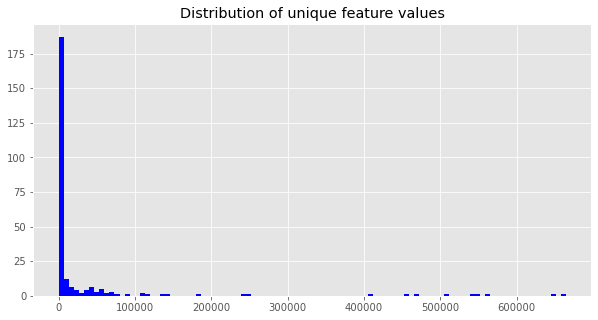

In [384]:
plt.title("Distribution of unique feature values");
F_nunique.hist(bins=100, figsize=(10, 5), color='b');

In [395]:
f_all = set(F_nunique.index.tolist())
len(f_all)

253

#### Constant features

In [396]:
f_const = set(F_nunique[F_nunique == 1].index.tolist())
len(f_const)

5

In [258]:
f_const

{'139', '203', '75', '81', '85'}

In [151]:
f[list(f_const)].head(2)

,81,75,85,139,203
id,,,,,
2046132,0.0,0.0,0.0,0.0,0.0
2050810,0.0,0.0,0.0,0.0,0.0


Constant features aren't needed. Let's **delete** them

In [205]:
# train.drop(columns=list(f_const), inplace=True)
# test.drop(columns=list(f_const), inplace=True)

#### Binary features

In [397]:
f_binary = set(F_nunique[F_nunique == 2].index.tolist())
len(f_binary)

20

In [291]:
train[list(f_binary)][list(f_binary)[0]].value_counts()

 0.039208    798909
-0.960792     32744
Name: 204, dtype: int64

In [292]:
train[list(f_binary)][list(f_binary)[1]].value_counts()

-0.334356    551507
 0.665644    280146
Name: 205, dtype: int64

It's like **normalized** data with an offset. Let's not touch them.

In [398]:
f_other = f_all - (f_const | f_binary)
len(f_other)

228

#### Categorical features

In [399]:
f_categorical = set(F_nunique.loc[list(f_other)][F_nunique.loc[list(f_other)] <= 10].index.tolist())
len(f_categorical)

9

In [302]:
train[list(f_categorical)][list(f_categorical)[0]].value_counts()

 1.426717    507859
-3.573283    156915
 0.426717     44657
-0.573283     43606
-1.573283     39909
-2.573283     38707
Name: 131, dtype: int64

In [400]:
f_other = f_other - f_categorical
len(f_other)

219

#### Numeric features

In [401]:
f_numeric = (f[list(f_other)].astype(int).sum() - f[list(f_other)].sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

218

#### Other features

In [402]:
f_other = f_other - f_numeric
len(f_other), f_other

(1, {'252'})

In [390]:
assert(F_nunique.shape[0] == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical) + len(f_other))

In [403]:
print(f'f_all: {len(f_all)}\n')
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))
print('f_other:', len(f_other))

f_ok = list(f_binary | f_categorical | f_numeric | f_other)
f_binary, f_categorical, f_numeric, f_other = list(f_binary), list(f_categorical), list(f_numeric), list(f_other)

f_all: 253

f_const: 5
f_binary: 20
f_categorical: 9
f_numeric: 218
f_other: 1


Let's look at this feature

In [317]:
f[list(f_other)].value_counts().shape

(34,)

In [318]:
f[list(f_other)].value_counts()

252   
0.0       674453
1.0       227888
2.0            5
8.0            3
3.0            3
4.0            3
10.0           3
11.0           2
13.0           2
7.0            2
5.0            2
446.0          1
77.0           1
299.0          1
284.0          1
283.0          1
251.0          1
223.0          1
195.0          1
182.0          1
84.0           1
82.0           1
24.0           1
68.0           1
44.0           1
42.0           1
36.0           1
23.0           1
22.0           1
19.0           1
18.0           1
16.0           1
6.0            1
1743.0         1
dtype: int64

It **looks like** a categorical feature, with some very **rare** objects.

In [355]:
train[train['252'] >= 2].target.value_counts()

0.0    39
1.0     4
Name: target, dtype: int64

In [354]:
train[(train['252'] >= 2) & (train['target'] == 1)]

,id,vas_id,buy_time,target,update_info_time,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
320995,4123710,2.0,1536526800,1.0,1531688400,-96.799971,-24.699112,-110.740786,-77.306798,-116.158246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,2.0
412050,1809707,6.0,1538341200,1.0,1535922000,495.570029,186.730888,481.629214,134.123202,476.211754,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,3.0
536191,3906738,4.0,1541970000,1.0,1536526800,540.910029,233.770888,526.969214,181.163202,521.551754,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,11.0
651830,2215612,6.0,1544994000,1.0,1540155600,-96.799971,-399.699112,-110.740786,-452.306798,-114.038246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,182.0


Since there are **~10%** of targets equal to **1**, then we cannot easily equate these categories with the largest strata **[0, 1]**. If this column is divided into categories, then the matrix will be **too sparse**. It will be possible to try to remove outliers and make a **binary** feature.

### Pipeline

In [392]:
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#### Make pipeline

In [391]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame does not have next columns: %s" % cols_error)

In [405]:
f_main = ['id', 'vas_id', 'buy_time', 'update_info_time']

In [486]:
f_prep_pipeline = make_pipeline(
    # ColumnSelector(columns = f_main + f_ok),
    FeatureUnion(transformer_list=[
        ("main_features", make_pipeline(
            ColumnSelector(f_main),
        )),
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            # StandardScaler()
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        )),
        ("other_features", make_pipeline(
            ColumnSelector(f_other),
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)

#### LGBM fit

In [487]:
lgb_pipe = make_pipeline(
    f_prep_pipeline,
    lightgbm.LGBMClassifier(objective='binary', random_state=1)
)

Best Threshold = 0.253, F-Score = 0.576, Precision = 0.420, Recall = 0.917
F1-Score (average="macro") = 0.7525469090834258
CPU times: user 1min 28s, sys: 34.1 s, total: 2min 2s
Wall time: 1min 25s


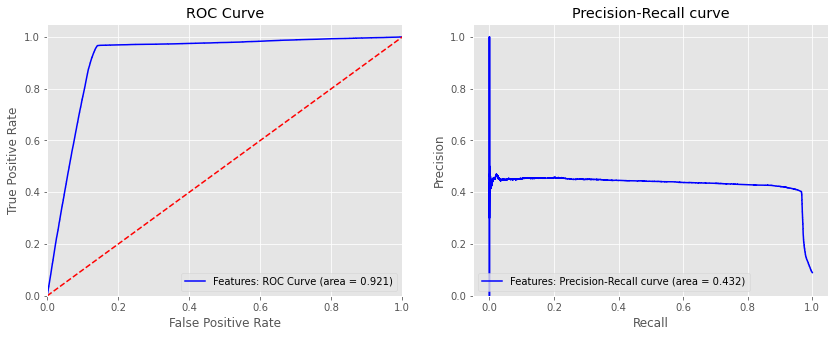

In [488]:
%%time
lgb_pipe = run_learn(train, lgb_pipe, slpit_date=SPLIT_DATE, plot_name='Features')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

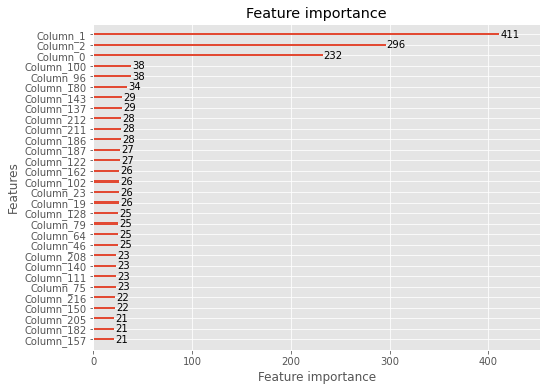

In [489]:
lightgbm.plot_importance(lgb_pipe[1], figsize=(8, 6) , max_num_features=30)